# Filtering the Florida Food Web network with disparity and threshold filtering

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

Load the directed and weighted network Florida Food Web Network and compare the two network
backboning methods discussed in class: threshold and disparity filter. Follow the steps below:


- Load the dataset and take the largest weakly connected component.

- For the threshold method:

    - (a) Implement the function threshold_filter(G, threshold) to remove edges with weights
    smaller than the threshold and eliminate isolated nodes.

    - (b) Generate 100 log-spaced threshold values from the minimum to maximum edge weight.

    - (c) Apply the filter for each threshold and record the fraction of retained nodes and edges.


- For the disparity filter:

    - (a) Compute the pi,j for each edge of the network and store these values as edge attributes.

    - (b) Generate 100 log-spaced alpha values from 0 to 1.

    - (c) Apply the disparity filter for each alpha and record the fraction of retained nodes and edges.

- Plot the fraction of retained nodes as a function of the fraction of retained edges for the threshold
and the disparity filter.

Discuss the differences between the two methods: what is the disparity filter preserving more/less then
the other filter? Which method would you prefer for the analysis of the Florida Food Web system?<br>
(hint: don’t plot just the lines but include the markers in the figure)

Points: 2 points for the implementation, 4 points for the discussion (total: 6 points)

## Load data, take the largest weakly connected component

In [2]:
G_nodes = pd.read_csv('./datasets/FloridaFoodWeb/nodes.csv')
G_nodes[:5]

,# index,_pos
0,0,"array([-1.07600464, 2.21835092])"
1,1,"array([-1.18825263, 2.14796785])"
2,2,"array([-1.07868553, 2.14938912])"
3,3,"array([-1.13583676, 2.21362314])"
4,4,"array([-1.19273229, 2.18059677])"


The positions are not stored in array format but in string, we need to convert them, e.g. with regex.

(Could also just remove the text in the strings and use `ast.literal_eval` to convert to a list of 2 numbers.)

In [3]:
import re
re.findall(r"-?\d+\.\d+", G_nodes[' _pos'][0])

['-1.07600464', '2.21835092']

Let's use this regex pattern, and also convert the values to floats from strings:

In [4]:
G_nodes[' _pos'] = G_nodes[' _pos'].apply(lambda x: [float(val) for val in re.findall(r"-?\d+\.\d+", x)])

In [5]:
G_edges = pd.read_csv('./datasets/FloridaFoodWeb/edges.csv')
G_edges[:5]

G = nx.DiGraph()
G.add_nodes_from([(row['# index'], {'pos': row[' _pos']}) for _, row in G_nodes.iterrows()])
G.add_edges_from([(row['# source'], row[' target'], {'weight': row[' weight']}) for _, row in G_edges.iterrows()])

We have one (weakly) connected graph, we do not need to select a subgraph.

In [6]:
len(list(nx.weakly_connected_components(G)))

1

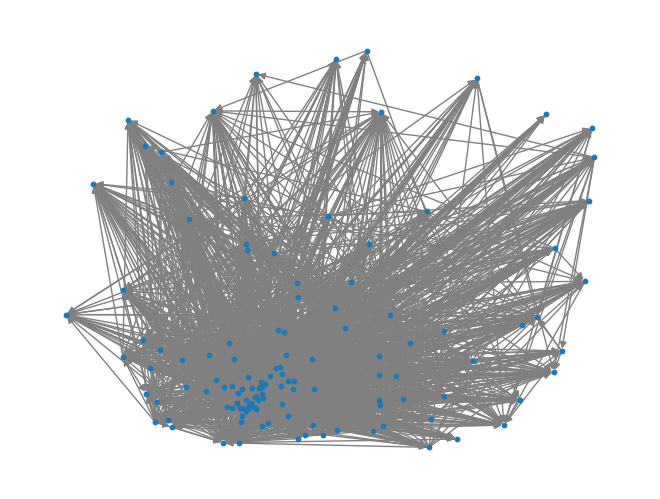

In [7]:
nx.draw(G, node_size=10, edge_color='gray', with_labels=False)

The graph is very dense and we need to filter it. Let's try two methods:

## Filter by threshold

We filter any edge with a weight below a certain threshold. We then remove any isolated nodes.

For higher thresholds, we get sparser graphs. Playing with the threshold parameter we can choose a sweet spot.

In [8]:
def threshold_filter(G, threshold):
    G_filtered = G.copy()
    for e in G.edges():
        if G.edges[e]['weight'] < threshold:
            G_filtered.remove_edge(*e)
    G_filtered.remove_nodes_from(list(nx.isolates(G_filtered)))
    return G_filtered

weights = np.array(G_edges[' weight'])
thresholds = np.logspace(np.log10(weights.min()), np.log10(weights.max()), 100)

threshold_edges_fractions = []
threshold_nodes_fractions = []
for threshold in thresholds:
    G_filtered = threshold_filter(G, threshold)
    threshold_edges_fractions.append(G_filtered.number_of_edges() / G.number_of_edges())
    threshold_nodes_fractions.append(G_filtered.number_of_nodes() / G.number_of_nodes())
threshold_fraction_of_fractions = [e/n for e,n in zip(threshold_edges_fractions, threshold_nodes_fractions)]

Let's see the fraction of edges above the threshold for different thresholds, and the same for nodes, and the (normalized) fraction of nodes vs edges.

(The maximum threshold is ~306.6, the end of the x-axis.)

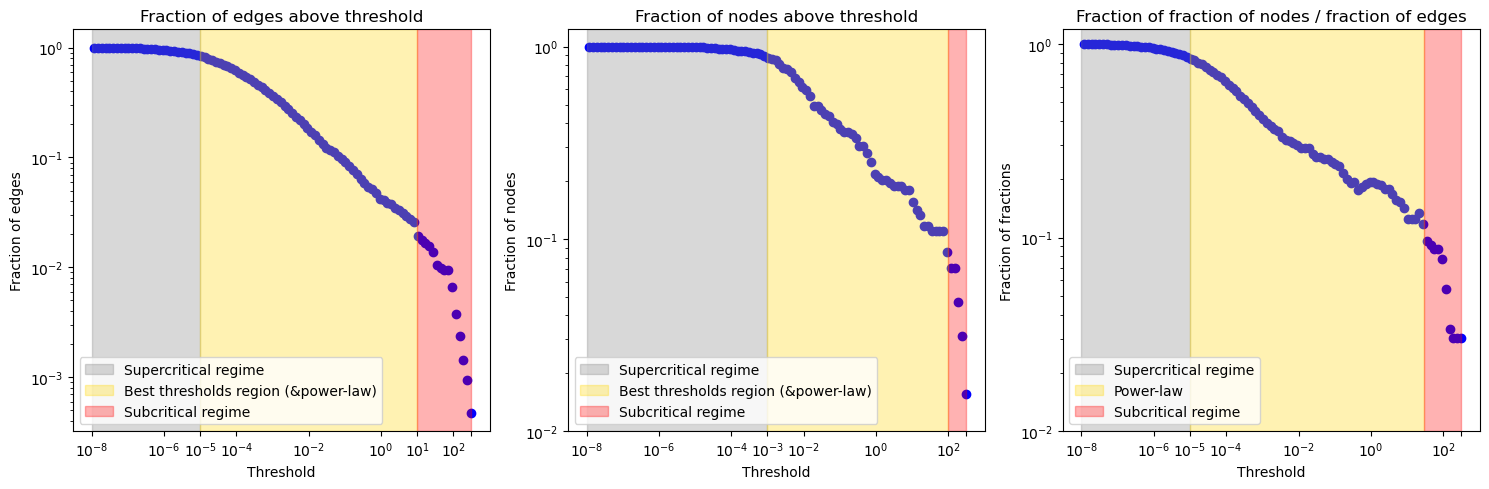

In [9]:
def plot_threshold_fractions(thresholds, fractions, title, xlabel, ylabel, vspan_intervals=None, yticks=None, xticks=None):

    plt.scatter(thresholds, fractions, color='blue')
    plt.yscale('log')
    plt.xscale('log')
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if yticks is not None:
        plt.yticks(yticks)
    if xticks is not None:
        plt.xticks(xticks)
    
    if vspan_intervals is not None:
        for interval0, interval1, color, label in vspan_intervals:
            plt.axvspan(interval0, interval1, color=color, alpha=0.3, label=label)
        plt.legend()



plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plot_threshold_fractions(
    thresholds, threshold_edges_fractions, 'Fraction of edges above threshold', 'Threshold', 'Fraction of edges',
    vspan_intervals=[(0.00000001, 0.00001, 'grey', 'Supercritical regime'), (0.00001, 10, 'gold', 'Best thresholds region (&power-law)'), (10, 307, 'red', 'Subcritical regime')],
    yticks=np.array([0.001, 0.01, 0.1, 1]), xticks=np.array([0.00000001, 0.000001, 0.00001, 0.0001, 0.01, 1, 10, 100, 307])
)

plt.subplot(1, 3, 2)
plot_threshold_fractions(
    thresholds, threshold_nodes_fractions, 'Fraction of nodes above threshold', 'Threshold', 'Fraction of nodes',
    vspan_intervals=[(0.00000001, 0.001, 'grey', 'Supercritical regime'), (0.001, 100, 'gold', 'Best thresholds region (&power-law)'), (100, 307, 'red', 'Subcritical regime')],
    yticks=np.array([0.01, 0.1, 1]), xticks=np.array([0.00000001, 0.000001, 0.0001, 0.001, 0.01, 1, 100, 307])
)

plt.subplot(1, 3, 3)
plot_threshold_fractions(
    thresholds, threshold_fraction_of_fractions, 'Fraction of fraction of nodes / fraction of edges', 'Threshold', 'Fraction of fractions',
    vspan_intervals=[(0.00000001, 0.00001, 'grey', 'Supercritical regime'), (0.00001, 30, 'gold', 'Power-law'), (30, 307, 'red', 'Subcritical regime')],
    yticks=np.array([0.01, 0.1, 1]), xticks=np.array([0.00000001, 0.000001, 0.00001, 0.0001, 0.01, 1, 100, 307])
)
#Legend on the bottom left
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()

We can see that this method typically has 3 different regimes:
- for small threshold values, stepwise increase of the threshold value only removes a few (if any) edges and nodes
- a subcritical regime when the network has already fallen apart and increases in threshold results in sudden drops especially in the number of nodes, but also in the number of edges
- an assumably most stable region of the possible threshold values where the number of nodes and edges decrease in a "power-law" fashion (power of the threshold, not degree of course).

The supercritical regime would yield a too dense network, the subcritical regime would yield a too sparse network. The critical regime seems to be that best captures the structure of the network.

## Filter by disparity

Every node has some local threshold for the weights of its edges. This is composed of the node's

$$ p_{ij} = (1 - \frac{w_{ij}}{s_{i}})^{k_i-1} $$

where $w_{ij}$ is the weight of the edge between $i$ and $j$, $s_{i}$ is the total strength of node $i$, and $k_i$ is the degree of node $i$.



(This is asymmetric, a reason behind using out-degree and out-strength is e.g. for hubs which have many incoming edges but few outgoing edges, the impact of the incoming edges is unimportant typically.)

In [10]:
def compute_disparity_filter_probas(G):
    edge_probas = {}
    for node in G.nodes():
        node_edges = G.edges(node, data='weight')
        k = len(node_edges)
        strength = sum([w for _, _, w in node_edges])

        for u, v, w in node_edges:
            p_ij = (1 - w / strength) ** (k - 1)
            edge_probas[(u, v)] = p_ij

    return edge_probas

edge_probas = compute_disparity_filter_probas(G)
alphas = np.logspace(-25, 0, 100) #10^-25 instead of 0

disparity_edges_fractions = []
disparity_nodes_fractions = []
for alpha in alphas:
    G_filtered = G.copy()
    for e in G.edges():
        if edge_probas[e] >= alpha:
            G_filtered.remove_edge(*e)
    G_filtered.remove_nodes_from(list(nx.isolates(G_filtered)))
    disparity_edges_fractions.append(G_filtered.number_of_edges() / G.number_of_edges())
    disparity_nodes_fractions.append(G_filtered.number_of_nodes() / G.number_of_nodes())
disparity_normalized_fractions = [e/n for e,n in zip(disparity_edges_fractions, disparity_nodes_fractions)]

I used $10^{-25}$ as the minimum alpha, as the smallest probability is around $10^{-27}$.

**NOTE**: I plot the x-axis reversed: from 1 to 0.

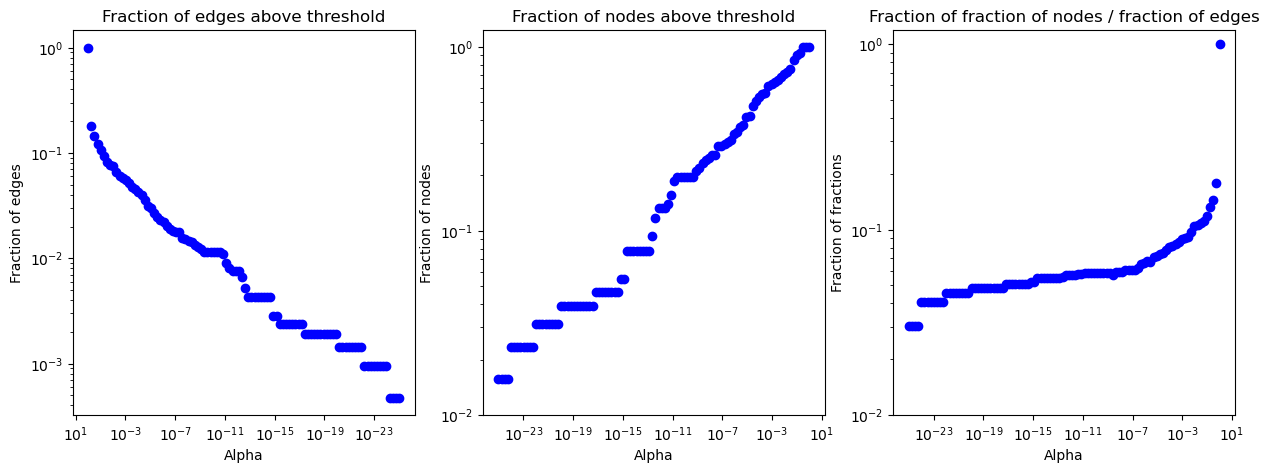

In [11]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plot_threshold_fractions(
    alphas, disparity_edges_fractions, 'Fraction of edges above threshold', 'Alpha', 'Fraction of edges',
    vspan_intervals=None,
    yticks=np.array([0.001, 0.01, 0.1, 1])
)
plt.gca().invert_xaxis()

plt.subplot(1, 3, 2)
plot_threshold_fractions(
    alphas, disparity_nodes_fractions, 'Fraction of nodes above threshold', 'Alpha', 'Fraction of nodes',
    yticks=np.array([0.01, 0.1, 1]),
)

plt.subplot(1, 3, 3)
plot_threshold_fractions(
    alphas, disparity_normalized_fractions, 'Fraction of fraction of nodes / fraction of edges', 'Alpha', 'Fraction of fractions',
    yticks=np.array([0.01, 0.1, 1])
)


I did not define any regions (vertical spans) for this plot, as the disparity filtering seems to follow a single trend and has no signs of phase transitions.

We already see a great reduction in the number of edges just by the highest alpha value, a sudden drop. This is opposite to the threshold filtering, where the number of edges decreases slowly at first, and has no sudden drops until the end.

## Comparison

Before discussing, let's look at the fraction of retained nodes and edges in comparison.

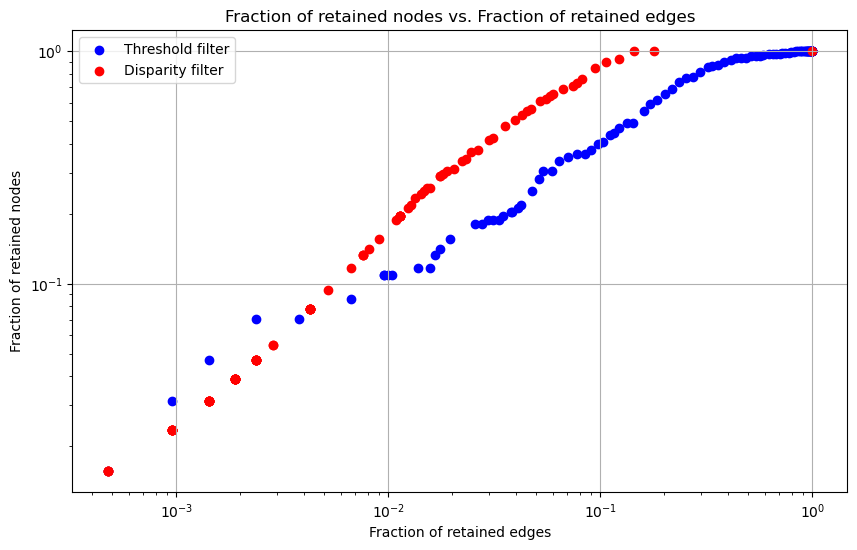

In [12]:
plt.figure(figsize=(10, 6))

plt.scatter(threshold_edges_fractions, threshold_nodes_fractions, label='Threshold filter', color='blue')
plt.scatter(disparity_edges_fractions, disparity_nodes_fractions, label='Disparity filter', color='red')

plt.xlabel('Fraction of retained edges')
plt.ylabel('Fraction of retained nodes')
plt.title('Fraction of retained nodes vs. Fraction of retained edges')
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.show()


One of the first observations from the plot is that the disparity filter can keep all of the nodes when keeping only <20% of the edges.<br>
This makes sense, as edge probabilities are computed only locally, and if the alpha value is high enough, every node will have an edge with strong enough weight that it is kept (due to local significance), resulting in no node being isolated and thus removed.<br>
This can be an advantage, if we want to keep the network as connected as possible and not lose any nodes.

From the threshold filtering plots, we observed that probably the best threshold values are in the range when 25-80% of the nodes are kept and 2-40% of the edges are kept. This region also represents the power-law like straight decrease (or increase) on this plot. The slope of a line that we can fit there is roughly $\frac{0.4-0.2}{0.1-0.03}=2.857..$ so in this range of threshold values, increasing the threshold would decrease the fraction of nodes stronger than the fraction of edges.<br>
In this range, using this method of filtering can also be an advantage, as it seems to keep the backbone part of the network but only keeps the globally high importance (weight) edges. It can remove redundant nodes quickly, if any.

From the strong power-law-like appearance of the disparity filtering plot, we can see that the disparity filter is more robust to alpha value changes, there are no sudden changes in the fraction of nodes and edges.<br>
This can be very important, as often we have constraints of how big of a network (e.g. in number of nodes) we have to keep, and this can robustly provide good results for any size. It also seems to keep the structure of the network for most alpha values. However, it does not seem to guide us to a "best" alpha value, the analysis does not suggest a range of alpha values that would bring forward a more significant subnetwork, meanwhile the threshold filtering does.


From this, I believe if our goal is to keep a subgraph with certain size of a big network, and we want to keep the structure of the network as much as possible, the disparity filter is the better choice. If we don't have such constraints and want to find the subgraph driving impact in the network (and filter out unimportant edges and nodes), the threshold filter is the better choice.